In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a regression problem.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis.
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization. -> 🎯 **Focus on this task** data preparation and feature selection (feature extraction part of sliding window method).
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.


# Imports + Settings

In [3]:
# third-party libraries
import pandas as pd
import numpy as np
import os
from typing import List, Union
import time
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from scipy import stats
from scipy.stats import multivariate_normal, zscore
from scipy.stats._mstats_basic import winsorize

In [23]:
# source code
from src.utils import load_data, load_config
from src.rolling_window_creator import RollingWindowDatasetCreator, calculate_RUL
from src.data_cleaning import identify_missing_values, identify_single_unique_features, format_dtype, clean_data

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
sns.set_context('notebook')

In [6]:
np.random.seed(42)

# Paths

In [7]:
os.chdir("../") # set working directory to root of project
#os.getcwd() # check current working directory

In [8]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load config + Data

In [9]:
config = load_config(PATH_TO_CONFIG) # config is dict

In [48]:
%%time
train_data, test_data, test_RUL_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=1)

2024-05-20 23:30:59 [src.utils:54] [INFO] >>>> Loading data set 1...
2024-05-20 23:30:59 [src.utils:83] [INFO] >>>> Loaded raw data for dataset 1.
2024-05-20 23:30:59 [src.utils:84] [INFO] >>>> Train Data: (20631, 26)
2024-05-20 23:30:59 [src.utils:85] [INFO] >>>> Test Data: (13096, 26)
2024-05-20 23:30:59 [src.utils:86] [INFO] >>>> Test RUL Data: (100, 1)
CPU times: total: 203 ms
Wall time: 354 ms


In [42]:
# count unit numbers in test set
print(f"Number of unique unit numbers in test set: {test_data['UnitNumber'].nunique()}")
# count min number of cycles in test set for each unit number --> window size must be in the range of these values, for example a window size of 10 would be too large if there is a unit number with only 10 cycles
print("Min number of cycles in test set for a unit number: ", test_data.groupby("UnitNumber")["Cycle"].count().min())

Number of unique unit numbers in test set: 100
Min number of cycles in test set for a unit number:  31


---
Test Data Cleaning Functionality and its impact on Rolling Window Creation

In [47]:
# clean data (with outlier removal, where no samples are dropped but the outliers are replaced, method='winsorize')
# TODO: outsource settings to config file
cleaned_train, cleaned_test = clean_data(train_data, test_data, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3, contamination=0.05)

2024-05-20 23:30:34 [src.data_cleaning:134] [INFO] >>>> Cleaning train and test data...
2024-05-20 23:30:34 [src.data_cleaning:136] [INFO] >>>> Formatting column types...
2024-05-20 23:30:34 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-20 23:30:34 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-20 23:30:34 [src.data_cleaning:141] [INFO] >>>> Handling duplicates...
2024-05-20 23:30:34 [src.data_cleaning:146] [INFO] >>>> Removing outliers...
2024-05-20 23:30:34 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: winsorize ...
2024-05-20 23:30:34 [src.outlier_detection:98] [DEBUG] >>>> Found 1031 outliers to be replaced (winsorized).
2024-05-20 23:30:34 [src.outlier_detection:100] [DEBUG] >>>> Original DataFrame shape: (20631, 26), Resulting DataFrame shape: (20631, 26)
2024-05-20 23:30:34 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: winsorize ...
2024-05-20 23:30:34 [src.outlier_de

In [49]:
# clean data (without outlier removal/replacement)
cleaned_train, cleaned_test = clean_data(train_data, test_data, method=None, ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3)

2024-05-20 23:31:06 [src.data_cleaning:134] [INFO] >>>> Cleaning train and test data...
2024-05-20 23:31:06 [src.data_cleaning:136] [INFO] >>>> Formatting column types...
2024-05-20 23:31:06 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-20 23:31:06 [src.data_cleaning:69] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-20 23:31:06 [src.data_cleaning:141] [INFO] >>>> Handling duplicates...
2024-05-20 23:31:06 [src.data_cleaning:146] [INFO] >>>> Removing outliers...
2024-05-20 23:31:06 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: None ...
2024-05-20 23:31:06 [src.outlier_detection:162] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-20 23:31:06 [src.outlier_detection:150] [DEBUG] >>>> Removing outliers using method: None ...
2024-05-20 23:31:06 [src.outlier_detection:162] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-20 23:31:06 [src.data_cleaning:

# Create Rolling Window Datasets

In [39]:
%%time
creator = RollingWindowDatasetCreator(column_id="UnitNumber",
                                      column_sort="Cycle",
                                      max_timeshift=config["preprocessing"]["max_window_size"],
                                      min_timeshift=config["preprocessing"]["min_window_size"],
                                      feature_extraction_mode='minimal')
X_train, y_train, X_test, y_test = creator.create_rolling_windows_datasets(train_data, test_data, test_RUL_data)

2024-05-20 23:17:29 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for train data...


Rolling: 100%|██████████| 37/37 [00:04<00:00,  7.74it/s]


2024-05-20 23:17:34 [src.rolling_window_creator:123] [INFO] >>>> Extracting features for train data...


Feature Extraction: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


2024-05-20 23:18:44 [src.rolling_window_creator:131] [INFO] >>>> Calculating target for train data...
2024-05-20 23:18:44 [src.rolling_window_creator:117] [INFO] >>>> Creating rolling windows for test data...


Rolling: 100%|██████████| 38/38 [00:03<00:00, 10.18it/s]


2024-05-20 23:18:48 [src.rolling_window_creator:123] [INFO] >>>> Extracting features for test data...


Feature Extraction: 100%|██████████| 40/40 [00:02<00:00, 16.16it/s]


2024-05-20 23:18:51 [src.rolling_window_creator:159] [INFO] >>>> Datasets created successfully.
2024-05-20 23:18:51 [src.rolling_window_creator:160] [INFO] >>>> Shape of X_train: (20131, 240)
2024-05-20 23:18:51 [src.rolling_window_creator:161] [INFO] >>>> Shape of y_train: (20131, 1)
2024-05-20 23:18:51 [src.rolling_window_creator:162] [INFO] >>>> Shape of X_test: (100, 240)
2024-05-20 23:18:51 [src.rolling_window_creator:163] [INFO] >>>> Shape of y_test: (100, 1)
CPU times: total: 36.2 s
Wall time: 1min 22s


Findings:
* Set 1 (with current settings):
    * Took ```Wall time: 54.4 s``` to create rolling windows for the training and test data **with** data cleaning.
    * Took ```Wall time: 1min 22s``` to create rolling windows for the training and test data **without** data cleaning.


In [ ]:
# load saved preprocessed data from pickle
#X_train = pd.read_pickle("data/processed/ex2_X_train_20240512-155504.pkl")
#y_train = pd.read_pickle("data/processed/ex2_y_train_20240512-155504.pkl")
#X_test = pd.read_pickle("data/processed/ex2_X_test_20240512-155504.pkl")
#y_test = pd.read_pickle("data/processed/ex2_y_test_20240512-155504.pkl")

# Data Preprocessing

## 1. Clean Data
* format column types - only necessary if categorical columns are present ✅
* handle missing values ✅
* handle single unique values ✅
* handle duplicates ✅
* handle outliers ✅
* handle correlated features ✅
* feature engineering ?
    * group features with rarely occurring realizations into buckets


### Format Column Types

In [ ]:
formatted_df = format_dtype(train_data)

### Handle Missing Values

In [ ]:
missing_features = identify_missing_values(train_data, threshold=0.1)
missing_features

In [ ]:
# drop features with missing values
train_data.drop(missing_features, axis=1, inplace=True)
test_data.drop(missing_features, axis=1, inplace=True)

### Handle Single Unique Values

In [ ]:
single_unique_features = identify_single_unique_features(train_data)
single_unique_features

In [ ]:
# drop features with single unique values
train_data.drop(single_unique_features, axis=1, inplace=True)
test_data.drop(single_unique_features, axis=1, inplace=True)

### Handle duplicates

In [ ]:
# get number of duplicates
print(f"Number of duplicates in train data: {train_data.duplicated().sum()}")
print(f"Number of duplicates in test data: {test_data.duplicated().sum()}")
# drop duplicates
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

### Handle Outliers
Possible Methods to investigate and possibly test:
* Z-Score ✅
* IQR ✅
* Winsorization ✅
* Isolation Forest ❌
* Local Outlier Factor (LOF) ✅
* Elliptic Envelope ✅

#### Z-Score
**Use Case**: Normally distributed data
**Assumption**: Assumes that the data follows a normal distribution. It identifies outliers based on how many standard deviations away from the mean a data point is.



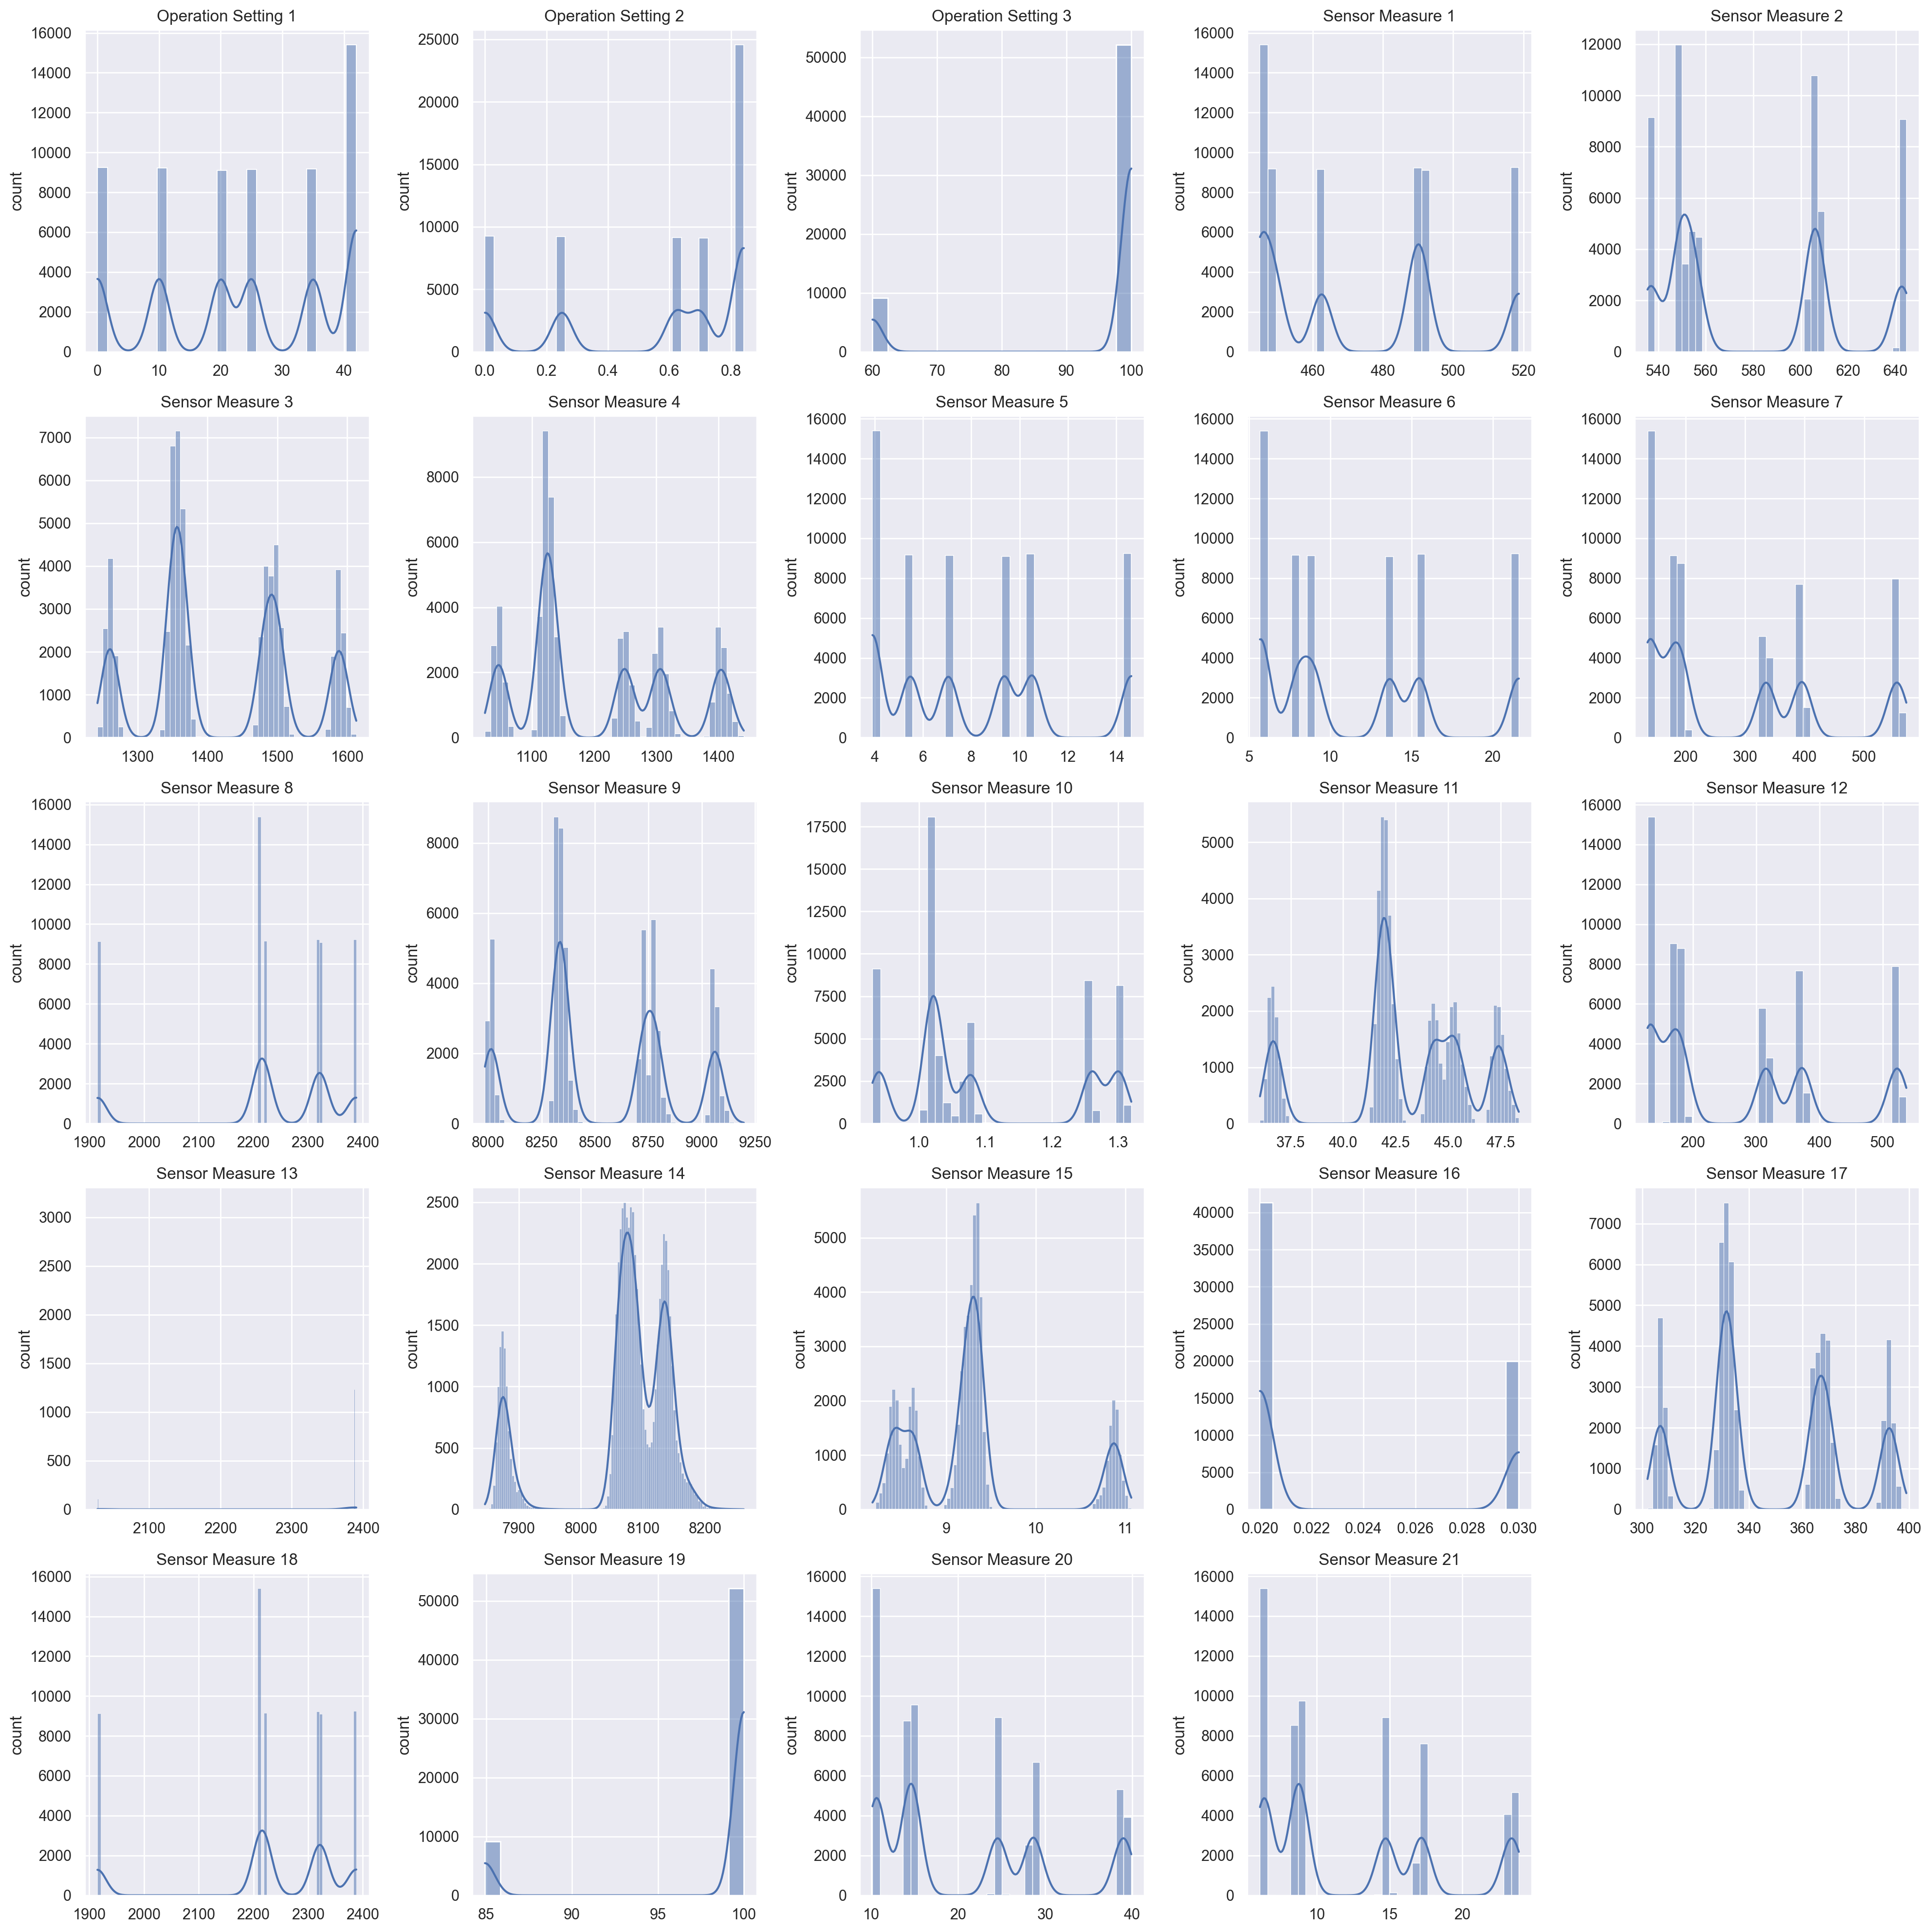

In [119]:
# visual inspection
plt.figure(figsize=(20, 20))
for i, col in enumerate(train_data.drop(['UnitNumber', 'Cycle'], axis = 1).columns):
    plt.subplot(5, 5, i+1)
    sns.histplot(train_data[col], kde=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('count')
plt.tight_layout()
plt.show()

Findings:
* ```Sensor Measure 6``` is highly skewed -> **investigate further**(drop feature), indicating non-normal distribution
* ```Operation Setting 2``` and ```Sensor Measure 17``` have multiple peaks and seem to only have a few unique numeric values -> **investigate further** (group into buckets, drop, etc.), indicating non-normal distribution
* All other features exhibit approximately normal distributions, indicated by a single peak with bell-shaped curves.

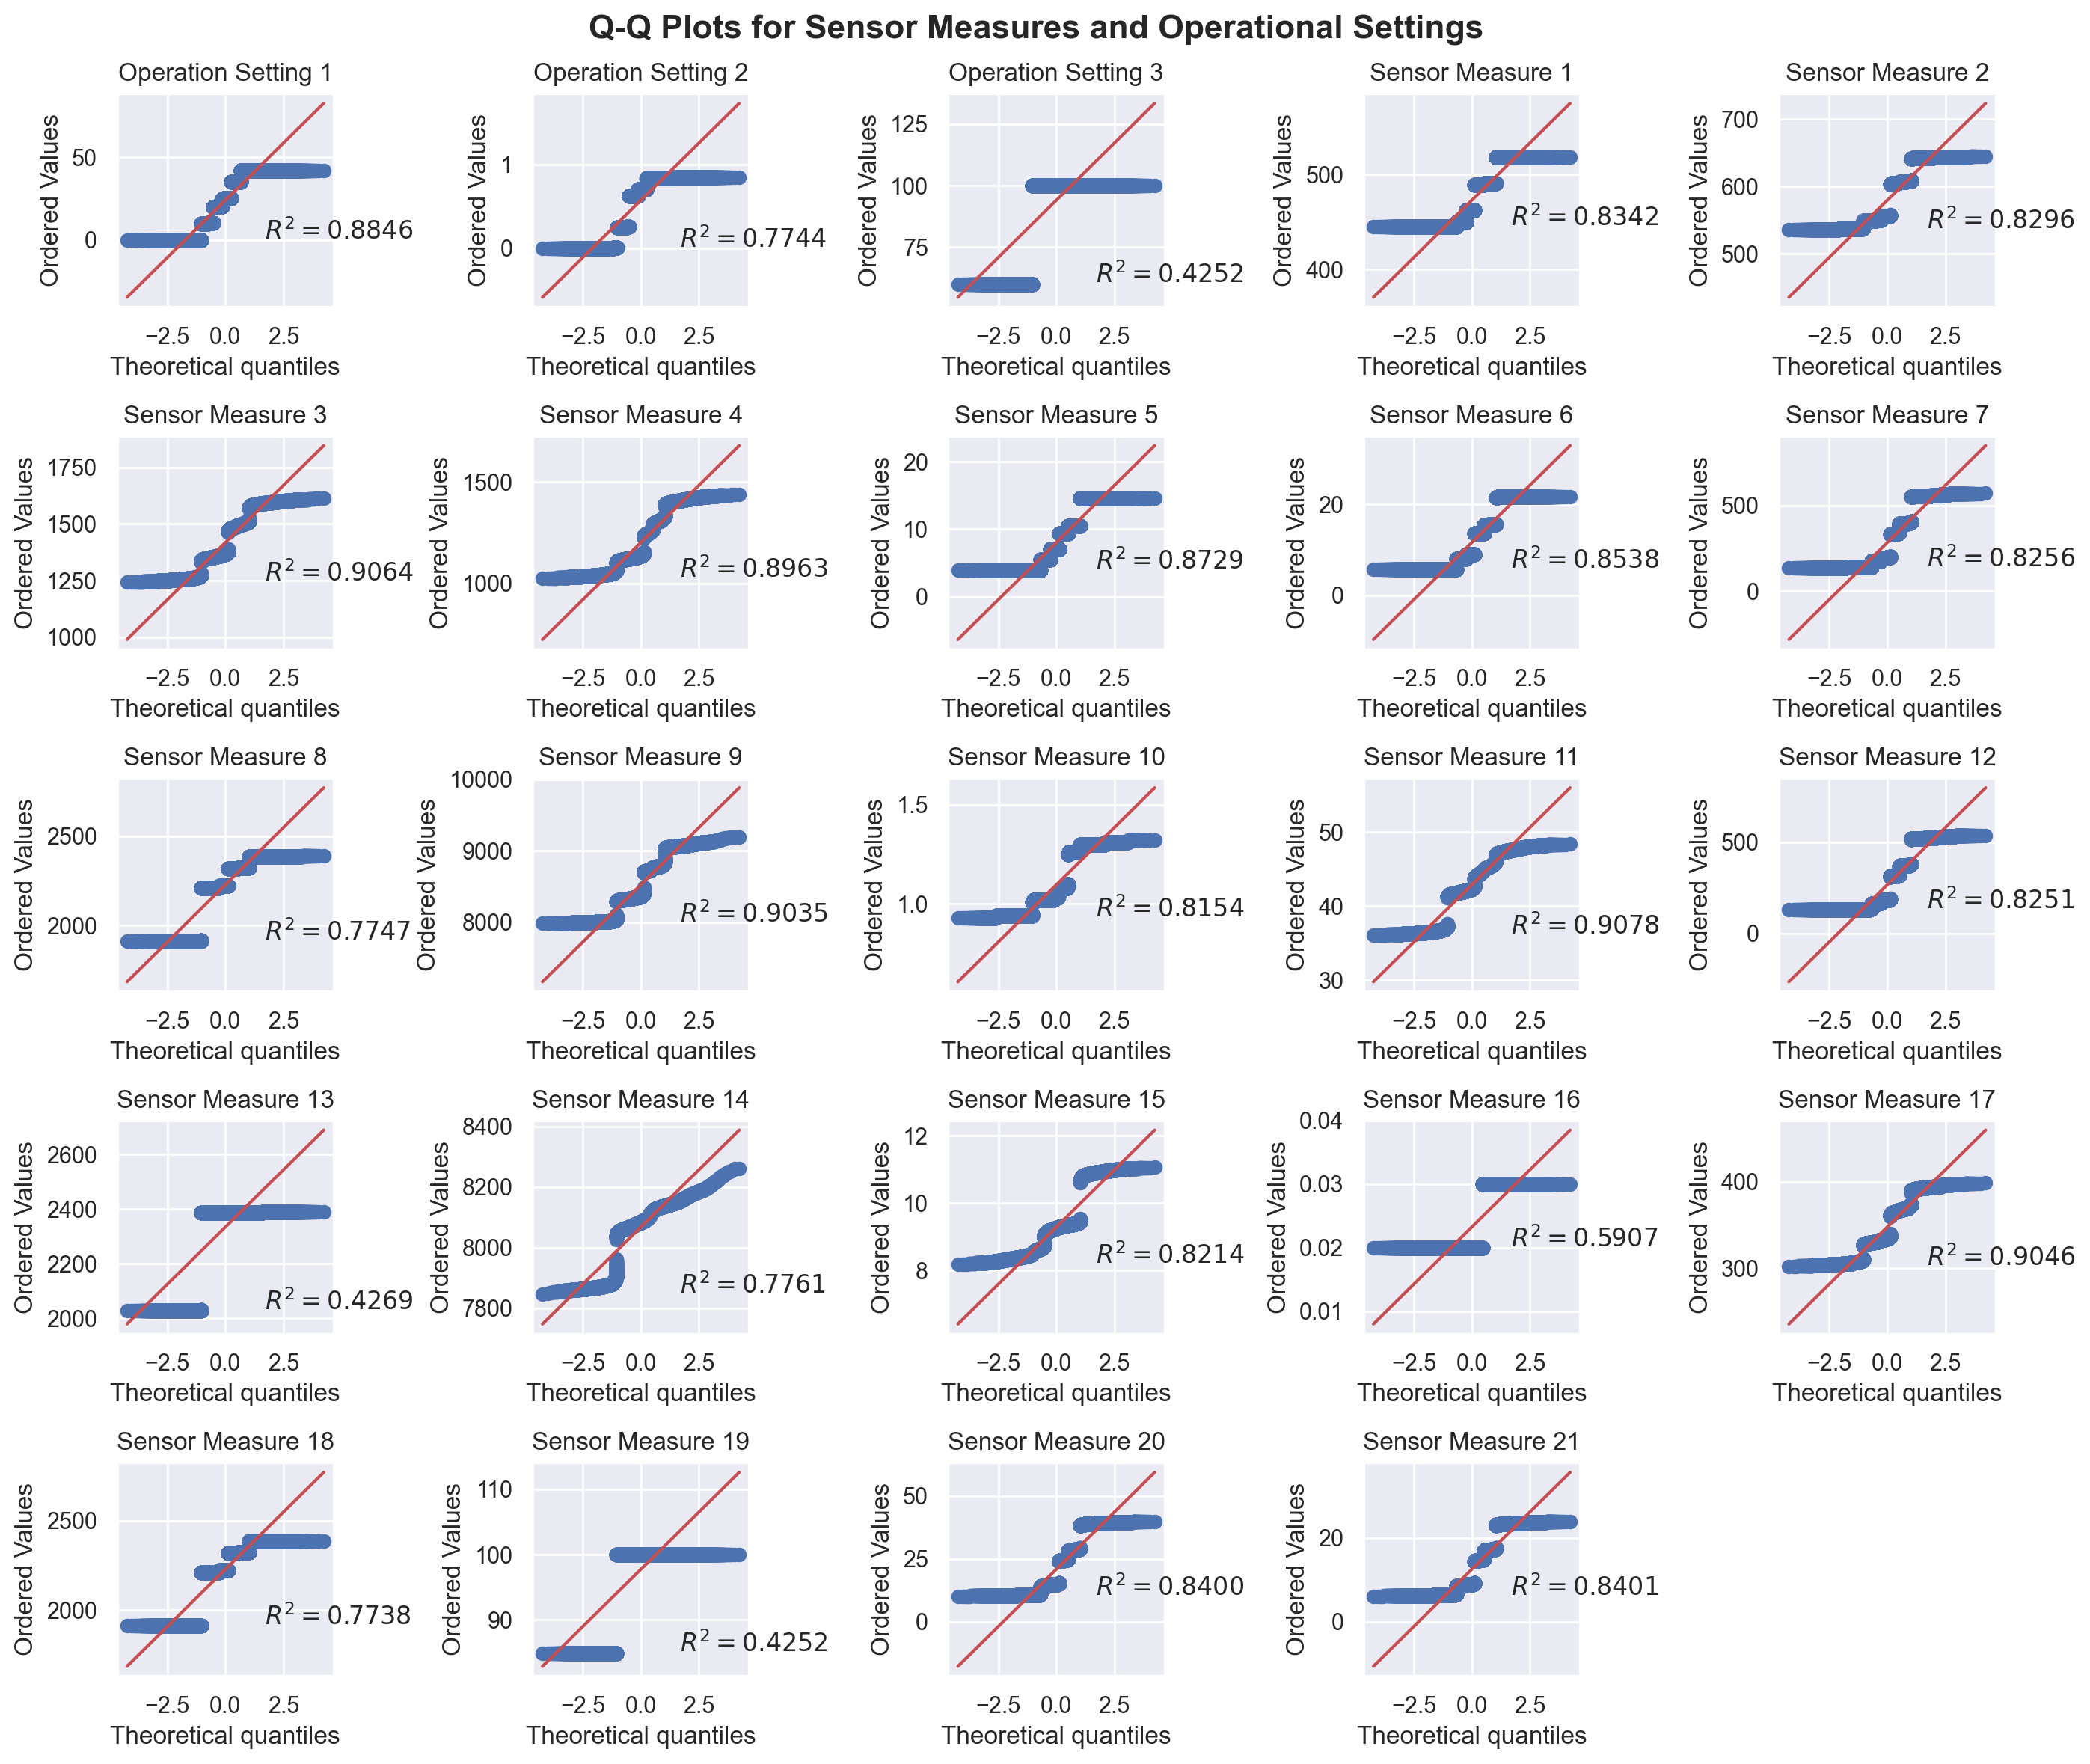

In [118]:
# Q-Q Plot for normally distributed data
plt.figure(figsize=(14, 12))
for i, col in enumerate(train_data.drop(['UnitNumber', 'Cycle'], axis = 1).columns):
    plt.subplot(5, 5, i+1)
    stats.probplot(train_data[col], dist="norm", plot=plt, fit=True, rvalue=True)
    plt.title(col)
plt.suptitle('Q-Q Plots for Sensor Measures and Operational Settings',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [135]:
def remove_outliers_zscore(df: pd.DataFrame, soft_drop: bool = False, threshold_sd: float = 0.5) -> pd.DataFrame:
    """Remove outliers using the Z-score method.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param soft_drop: Boolean to indicate whether to softly drop outliers.
    :type soft_drop: bool
    :param threshold_sd: The minimum proportion of outliers in a sample (row) to consider for soft dropping.
    :type threshold_sd: float

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame
    """
    z_scores = zscore(df)
    threshold = 3

    if soft_drop:
        outlier_proportion = (np.abs(z_scores) > threshold).mean(axis=1)
        num_samples_soft_dropped = outlier_proportion[outlier_proportion > threshold_sd].shape[0]
        print(f"Number of samples to be softly dropped: {num_samples_soft_dropped}")
        result_df = df[(np.abs(z_scores) < threshold).all(axis=1) | (outlier_proportion <= threshold_sd)]
    else:
        num_samples_dropped = df[~(np.abs(z_scores) < threshold).all(axis=1)].shape[0]
        print(f"Number of samples to be dropped: {num_samples_dropped}")
        result_df = df[(np.abs(z_scores) < threshold).all(axis=1)]

    print(f"Original DataFrame shape: {df.shape}, Resulting DataFrame shape: {result_df.shape}")
    return result_df

In [157]:
train_data_cleaned = remove_outliers_zscore(train_data.drop(['UnitNumber', 'Cycle'], axis=1), soft_drop=True, threshold_sd=0.3)

Number of samples to be softly dropped: 0
Original DataFrame shape: (61249, 24), Resulting DataFrame shape: (61249, 24)


#### IQR
**Use Case**: Non-normally distributed data
**Assumption**: Suitable for data that may not follow a normal distribution. It defines outliers based on the spread of the middle 50% of the data, rather than assuming a specific distribution.

* --> Use IQR for non-normally distributed data. Could be useful since depending on the datset the data might not be normally distributed. As can also be seen in some of the histograms above.
* ✅ **Use IQR for outlier detection.**



In [152]:
def remove_outliers_iqr(df: pd.DataFrame, threshold_iqr: float = 1.5, threshold_sd: float = 0.3 , soft_drop: bool = False) -> pd.DataFrame:
    """Remove outliers using the IQR method.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param threshold: The threshold for the outlier detection method.
    :type threshold: float
    :param soft_drop: Boolean to indicate whether to softly drop outliers.
    :type soft_drop: bool

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold_iqr * IQR
    upper_bound = Q3 + threshold_iqr * IQR

    if soft_drop:
        outlier_proportion = ((df < lower_bound) | (df > upper_bound)).mean(axis=1)
        num_samples_soft_dropped = outlier_proportion[outlier_proportion > threshold_sd].shape[0]
        print(f"Number of samples to be softly dropped: {num_samples_soft_dropped}")
        result_df = df[((df < lower_bound) | (df > upper_bound)).all(axis=1) | (outlier_proportion <= threshold_sd)]
    else:
        num_samples_dropped = df[~((df < lower_bound) | (df > upper_bound)).all(axis=1)].shape[0]
        print(f"Number of samples to be dropped: {num_samples_dropped}")
        result_df = df[((df < lower_bound) | (df > upper_bound)).all(axis=1)]

    print(f"Original DataFrame shape: {df.shape}, Resulting DataFrame shape: {result_df.shape}")
    return result_df

In [156]:
train_data_cleaned = remove_outliers_iqr(train_data.drop(['UnitNumber', 'Cycle'], axis=1), soft_drop=True, threshold_sd=0.3)

Number of samples to be softly dropped: 3102
Original DataFrame shape: (61249, 24), Resulting DataFrame shape: (58147, 24)


#### Winsorization
**Use Case**: Non-normally distributed data, when you need to reduce the influence of outliers without removing data points.
**Assumption**: It doesn't assume any specific distribution but instead modifies extreme values to be less influential while preserving the data's overall distribution.

* --> Could be useful since it doesn't assume a specific distribution. Also it does not remove data points, which could be beneficial in some cases.
* ✅ **Use Winsorization for outlier detection.**

In [161]:
def remove_outliers_winsorize(df: pd.DataFrame, ignore_columns: List[str] = None, contamination: float = 0.05) -> pd.DataFrame:
    """Remove outliers using the Winsorization method. This method replaces the extreme values with the threshold value. The threshold value is determined by the proportion of outliers in the data set.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param ignore_columns: The columns to ignore when handling outliers.
    :type ignore_columns: list
    :param contamination: The proportion of outliers which are considered as such. Default is 0.05. If 0.05 then the upper and lower 5% of the data are considered as outliers. They are replaced by the 5th and 95th percentiles respectively.
    :type contamination: float

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame
    """
    if ignore_columns is None:
        ignore_columns = []

    num_outliers = int(df.shape[0] * contamination)
    print(f"Number of outliers to be replaced: {num_outliers}")
    result_df = df.apply(lambda x: winsorize(x, limits=[contamination, contamination]) if x.name not in ignore_columns else x)
    print(f"Original DataFrame shape: {df.shape}, Resulting DataFrame shape: {result_df.shape}")

    return result_df

In [162]:
train_data_cleaned = remove_outliers_winsorize(train_data.drop(['UnitNumber', 'Cycle'], axis=1), contamination=0.05)

Number of outliers to be replaced: 3062
Original DataFrame shape: (61249, 24), Resulting DataFrame shape: (61249, 24)


#### Isolation Forest
**Use Case**: High-dimensional data
**Assumption**: Effective for high-dimensional data where traditional distance-based methods might struggle. It works by isolating outliers in a way that separates them from the rest of the data using a tree-based approach.

* --> High-dimensional data refers to data sets for which the number of variables or dimensions $p$ is much larger than the number of observations $n$, typically $p >> n$. Source: Giraud, C. (2015). *Introduction to High-Dimensional Statistics*. CRC Press.
* ❌ **Not** our case (Shape of X_train: (20131, 170))

#### Local Outlier Factor (LOF)
**Use Case**: Effective for datasets with varying densities.
**Assumption**: LOF is useful for datasets where the density of points varies across the dataset. It calculates the local density around each data point and identifies outliers as points with significantly lower densities compared to their neighbors.

* --> LOF well-suited for our dataset, which exhibits heterogeneous density distributions (see plots).
* ✅ **Use LOF for outlier detection.**

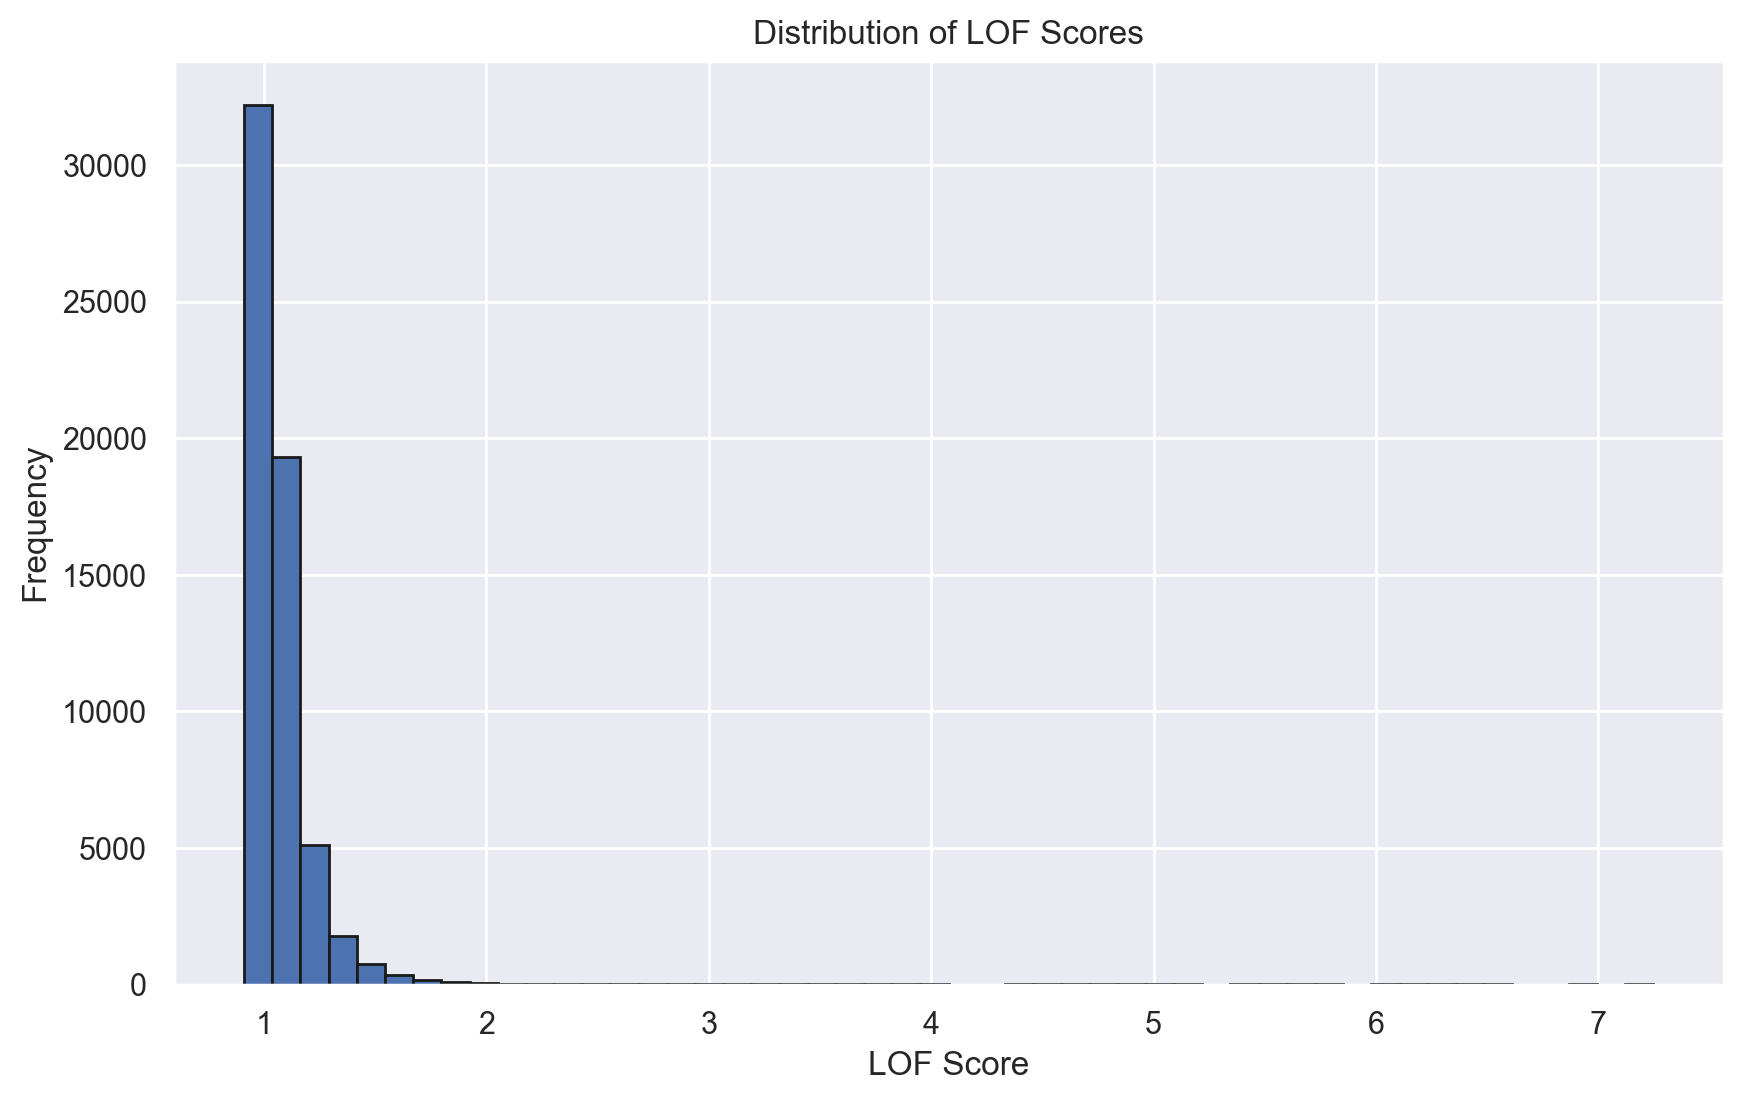

In [176]:
# fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed
lof.fit(X_train)

# calc LOF scores
lof_scores = -lof.negative_outlier_factor_

# plot
plt.figure(figsize=(10, 6))
plt.hist(lof_scores, bins=50, edgecolor='k')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.grid(True)
plt.show()

Findings:
* Presence of scores below 1 indicates regions of exceptionally high data density. --> No outliers in these regions.
* Peak around 1.0 indicates regions of average data density, clustered around a normal density level.
* Gradual decrease in frequency suggests lower density regions.
* Sharp drop at 1.3 may represent areas of lower data density, where outliers may start to emerge.

In [174]:
def remove_outliers_with_lof(df: pd.DataFrame, contamination: float = 0.05) -> pd.DataFrame:
    """Handle outliers using the Local Outlier Factor (LOF) method. This method calculates the local density around each data point and identifies outliers as points with significantly lower densities compared to their neighbors.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param contamination: The proportion of outliers in the data set. Default is 0.05.
    :type contamination: float

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame
    """
    # fit the LOF model
    lof = LocalOutlierFactor(contamination=contamination, novelty=False)
    yhat = lof.fit_predict(df)
    lof_scores = -lof.negative_outlier_factor_

    result_df = df[yhat != -1]
    print(f"Number of samples to be dropped: {df.shape[0] - result_df.shape[0]}")
    print(f"Original DataFrame shape: {df.shape}, Resulting DataFrame shape: {result_df.shape}")

    return result_df

In [175]:
train_data_cleaned = remove_outliers_with_lof(X_train, contamination=0.05)

Number of samples to be dropped: 3001
Original DataFrame shape: (60004, 241), Resulting DataFrame shape: (57003, 241)


#### Elliptic Envelope
**Use Case**: Assumes the data is normally distributed and identifies points that are far from the center. Suitable for multivariate normally distributed data.
**Assumption**: Assumes the data is multivariate normally distributed and aims to identify outliers by fitting an ellipse around the central data points. Points outside this ellipse are considered outliers.

* --> The data is not perfectly multivariate normal, but the method can still be used. See below in the plot.
* ✅ **Use Elliptic Envelope for outlier detection.*



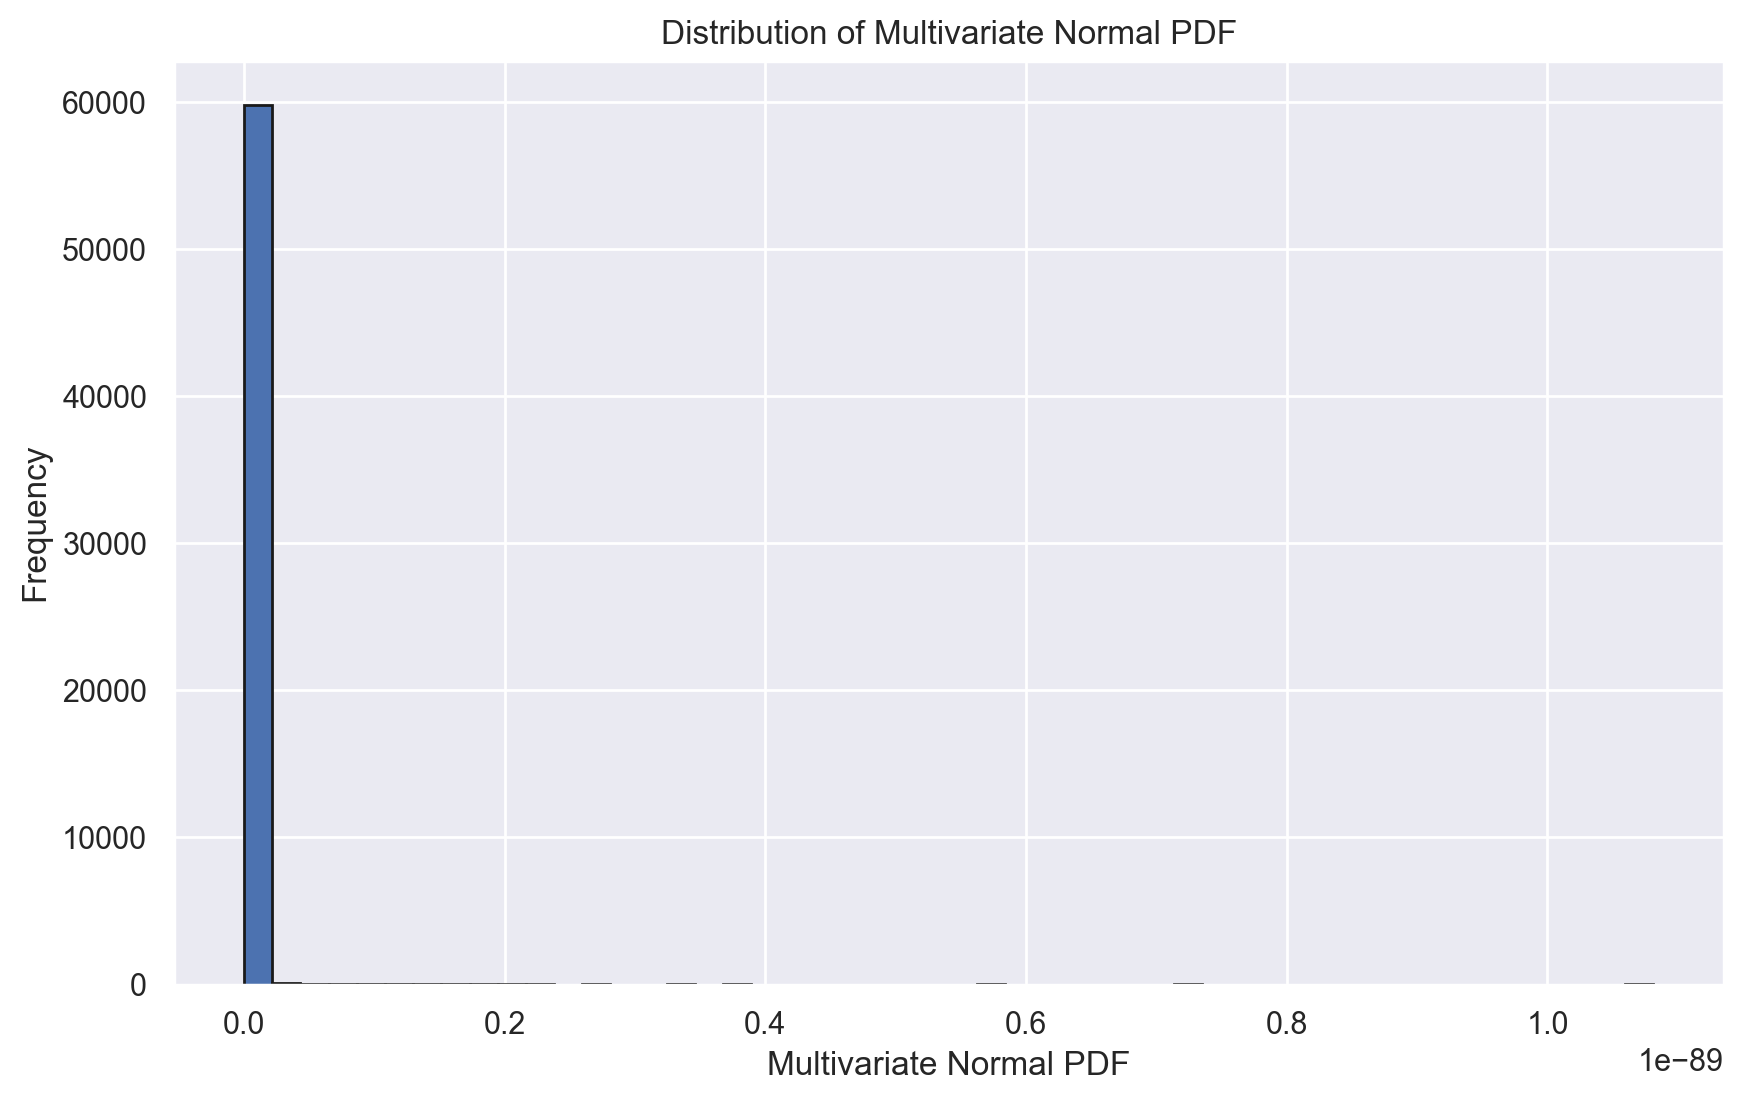

In [120]:
# check for multivariate normality
# fit a multivariate normal distribution to the data
mu = X_train.mean(axis=0)
sigma = X_train.cov()
mvn = multivariate_normal(mean=mu, cov=sigma, allow_singular=True)
# calculate the PDF for the data
X_train['mvn'] = mvn.pdf(X_train)
# plot
plt.figure(figsize=(10, 6))
plt.hist(X_train['mvn'], bins=50, edgecolor='k')
plt.xlabel('Multivariate Normal PDF')
plt.ylabel('Frequency')
plt.title('Distribution of Multivariate Normal PDF')
plt.grid(True)
plt.show()

Findings:
* Majority of data points: Most have multivariate normal PDF value close to 0. Considered typical or normal.
* Sparse spread: Some data points spread up to 1.0. Possibly outliers or less typical observations.
* Gap between 0.5 and 1.0: Indicates regions of lower density. Less common patterns in the data.
--> Majority close to center, typical. Some deviate, potentially outliers. The data is not perfectly multivariate normal, but the method can still be used.

### Summary of Outlier Detection

In [183]:
def remove_outliers(df: pd.DataFrame, method: str = 'winsorize', ignore_columns: List[str] = None, contamination: float = 0.05, threshold_sd: float = 0.8, soft_drop: bool = False) -> pd.DataFrame:
    """Remove outliers from the input DataFrame using the specified method.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param method: The outlier detection method to use. Options: 'zscore', 'iqr', 'winsorize', 'lof', 'elliptic'.
    :type method: str
    :param ignore_columns: The columns to ignore when handling outliers.
    :type ignore_columns: list
    :param contamination: The proportion of outliers in the data set. Default is 0.05.
    :type contamination: float
    :param threshold_sd: The minimum proportion of outliers in a sample (row) to consider for soft dropping. Default is 0.8.
    :type threshold_sd: float
    :param soft_drop: Boolean to indicate whether to softly drop outliers.
    :type soft_drop: bool

    :return: The DataFrame with outliers removed.
    :rtype: pd.DataFrame
    """
    if ignore_columns is None:
        ignore_columns = []

    if method == 'zscore':
        result_df = remove_outliers_zscore(df, soft_drop=soft_drop, threshold_sd=threshold_sd)
    elif method == 'iqr':
        result_df = remove_outliers_iqr(df, soft_drop=soft_drop, threshold_sd=threshold_sd)
    elif method == 'winsorize':
        result_df = remove_outliers_winsorize(df, ignore_columns=ignore_columns, contamination=contamination)
    elif method == 'lof':
        result_df = remove_outliers_with_lof(df, contamination=contamination)
    else:
        raise ValueError(f"Invalid method: {method}. Please choose from 'zscore', 'iqr', 'winsorize', 'lof'.")

    return result_df

In [180]:
# remove outliers using the specified method
train_data_cleaned = remove_outliers(X_train, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], contamination=0.05, threshold_sd=0.8, soft_drop=False)

Number of outliers to be replaced: 3000
Original DataFrame shape: (60004, 241), Resulting DataFrame shape: (60004, 241)


### Handle Correlated Features

In [16]:
def get_uncorrelated_features(df: pd.DataFrame, threshold: float = 0.9, target: str = None) -> List[str]:
    """
    Get features from the input DataFrame that are not highly correlated with the target column.

    :param df: The input DataFrame.
    :type df: pd.DataFrame
    :param threshold: The correlation threshold to use. Default is 0.9.
                      Features with an absolute correlation coefficient less than this value with the target are considered uncorrelated.
    :type threshold: float
    :param target: The target column name. Default is None.
    :type target: str

    :return: The list of uncorrelated feature names.
    :rtype: List[str]
    """

    if target and target not in df.columns:
        raise ValueError(f"Target column '{target}' is not in the DataFrame.")

    corr_matrix = df.corr().abs()

    if target:
        target_corr = corr_matrix[target].drop(target)
        uncorrelated_features = target_corr[target_corr < threshold].index.tolist()
    else:
        uncorrelated_features = df.columns.tolist()

    print(f"Found {len(uncorrelated_features)} uncorrelated features with a correlation threshold of {threshold}.")

    return uncorrelated_features

In [21]:
train_with_target = calculate_RUL(train_data, time_column='Cycle', group_column='UnitNumber')
uncorrelated_features = get_uncorrelated_features(train_with_target, threshold=0.3, target='RUL')
uncorrelated_features

Found 4 uncorrelated features with a correlation threshold of 0.3.


['UnitNumber',
 'Operation Setting 1',
 'Operation Setting 2',
 'Sensor Measure 6']

## Summary of data cleaning in one function

In [33]:
# clean data without outlier removal
cleaned_train, cleaned_test = clean_data(train_data, test_data, method=None, ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3)

2024-05-20 23:03:05 [src.data_cleaning:134] [INFO] >>>> Cleaning train and test data...
2024-05-20 23:03:05 [src.data_cleaning:69] [INFO] >>>> Found 0 categorical columns: []
2024-05-20 23:03:05 [src.data_cleaning:69] [INFO] >>>> Found 0 categorical columns: []
2024-05-20 23:03:05 [src.data_cleaning:26] [INFO] >>>> Found 0 features with missing values above the threshold of 0.1.
2024-05-20 23:03:05 [src.data_cleaning:26] [INFO] >>>> Found 0 features with missing values above the threshold of 0.1.
2024-05-20 23:03:05 [src.outlier_detection:160] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-20 23:03:05 [src.outlier_detection:160] [INFO] >>>> No outlier detection method specified. Skipping outlier detection.
2024-05-20 23:03:05 [src.data_cleaning:151] [INFO] >>>> Dropping features based train data...
2024-05-20 23:03:05 [src.data_cleaning:46] [INFO] >>>> Found 0 features with only a single unique value: []
2024-05-20 23:03:05 [src.data_cleaning:103

In [35]:
# clean data with outlier removal, where no samples are dropped but the outliers are replaced
cleaned_train, cleaned_test = clean_data(train_data, test_data, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.1, threshold_corr=0.3, contamination=0.05)

2024-05-20 23:09:10 [src.data_cleaning:134] [INFO] >>>> Cleaning train and test data...
2024-05-20 23:09:10 [src.data_cleaning:69] [INFO] >>>> Found 0 categorical columns: []
2024-05-20 23:09:10 [src.data_cleaning:69] [INFO] >>>> Found 0 categorical columns: []
2024-05-20 23:09:10 [src.outlier_detection:98] [INFO] >>>> Number of outliers to be replaced: 1031
2024-05-20 23:09:10 [src.outlier_detection:100] [INFO] >>>> Original DataFrame shape: (20631, 16), Resulting DataFrame shape: (20631, 16)
2024-05-20 23:09:10 [src.outlier_detection:98] [INFO] >>>> Number of outliers to be replaced: 654
2024-05-20 23:09:10 [src.outlier_detection:100] [INFO] >>>> Original DataFrame shape: (13096, 16), Resulting DataFrame shape: (13096, 16)
2024-05-20 23:09:10 [src.data_cleaning:147] [INFO] >>>> Filter and drop features based train data...
2024-05-20 23:09:10 [src.data_cleaning:26] [INFO] >>>> Found 0 features with missing values above the threshold of 0.1.
2024-05-20 23:09:10 [src.data_cleaning:46] [

# 2. Post-Windowing Preprocessing (if necessary)
Additional preprocessing steps after feature extraction if needed
* handle correlated features

# 3. Feature Selection [TBD]

Orientation:
![Feature Selection](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Potential Feature Selection Methods:
* Supervised:
    * Filter Methods:
        * Numerical Input, Numerical Output:
                * Pearson’s correlation coefficient (linear)
                * Spearman’s rank coefficient (nonlinear)
        * --> Using Pearson’s Correlation Coefficient via the f_regression() function and SelectKBest (feature selection strategy).
        * --> Using Mutual Information via the mutual_info_regression() function and SelectKBest (feature selection strategy).
    * Wrapper Methods:
        * Recursive Feature Elimination (RFE)
        * --> Using RFE with a linear model (e.g., linear regression).

# 4. Dimensionality Reduction [TBD]
Only if certain number of features is above a certain threshold.
